# 4. pix2pix with the Victorian400 dataset

이전장에서는 GAN 모델을 이용하여, 흑백 이미지를 컬러 이미지로 변환해보았습니다. 

이번장에서는 cGAN (conditional Generative Adversarial Network) 기반인 [pix2pix](https://phillipi.github.io/pix2pix/) 모델과 19세기 일러스트로 이루어진 [Victorian400](https://www.kaggle.com/elibooklover/victorian400) 데이터셋을 이용하여, 해당 모델을 학습하고 색채를 입히는 테스트 해보도록 하겠습니다.

우선 [Victorian400](https://www.kaggle.com/elibooklover/victorian400) 데이터셋을 내려 받도록 하겠습니다. 가짜연구소에서 제작한 툴을 통해 해당 데이터셋을 내려받고 압축을 풀도록 하겠습니다.

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 7), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), done.
Victorian400-GAN-colorization-data.zip is done!


기본적인 모듈들을 import 해줍니다.

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

배치 사이즈와 이미지 사이즈를 미리 지정해줍니다. 폴더 위치를 `root`로 지정해줍니다. 이미지 사이즈의 경우 높이와 가로 모두 256으로 맞춰줍니다. pix2pix 모델의 경우 256 X 256 이미지 사이즈를 활용합니다. (추가 할 것)

In [3]:
batch_size = 1
img_height = 256
img_width = 256

root = ''

`ImageDataset` 클래스는 흑백사진(gray)과 컬러사진(resized)을 함께 파일명 순서대로 불러오는 `__init__` 함수, 각각의 이미지 파일을 픽셀로 저장하는 `__getitem__` 함수, 파일 갯수를 반환하는 `__len__` 함수가 지정되어 있습니다. `transform.Normalize`에서 `Normalize` 크기를 지정해줍니다.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transform = transforms.Compose(transforms_)

        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("RGB")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.transform(gray_img)
        color_img = self.transform(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)

In [5]:
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [6]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True
)

이제 불러온 데이터가 픽셀로 잘 저장이 되었는지, 시각화 해보도록 하겠습니다.

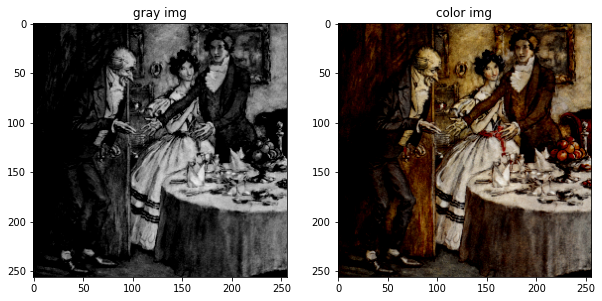

In [7]:
## dataloader에 잘 들어갔는지 확인할 수 있습니다 ##

fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in dataloader:
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)), 0, 1))
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

이제 pix2pix 모델을 설계하도록 하겠습니다. pix2pix의 특징은 일반적인 인코더-디코더(Encoder-Decoder)보다는 U-NET을 사용합니다. U-NET의 특징은 일반적인 인코더-디코어와 달리 스킵 커넥션 (Skip Connections)이 있어, 인코더 레이어와 디코더 레이어 간의 연결을 보다 로컬라이징(localization)을 잘 해주는 특징이 있습니다. 예를 들어, 첫 인코더 레이어 크기가 256 x 256 x 3이라면, 마지막 디코더 레이어 크기도 똑같이 256 x 256 x 3이게 됩니다. 이렇게 같은 크기의 인코더-디코더 레이어가 결합하여, 보다 효과적이고 빠른 성능을 발휘할 수 있게 하는게 U-NET의 특징입니다.

이제 스킵 커넥션이 내장된 생성자(Generator)와 구분자(Discriminator)가 있는 U-NET을 설계해보도록 하겠습니다. 앞장에서 설명했듯이, GAN 모델에는 생성자(Generator)와 구분자(Discriminator)가 존재합니다.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [15]:
gpu = 0

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

이제 패러미터를 지정하고 pix2pix 모델을 학습해보도록 하겠습니다. 학습에 필요한 기본적인 모듈들을 불러옵니다.

In [18]:
import argparse
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

이제 세부적인 패러미터를 지정하도록 하겠습니다. 여기서 `epoch`은 0에서 시작하며 `n_epoch`은 에폭 횟수를 의미합니다. `batch_size`는 메모리 용량에 따라 배수로 조정을 하고, `lr`는 학습 손실값(Learning Loss)을 의미합니다. `sample_interval`은 학습중 샘플 파일을 출력하는 간격값입니다.

In [19]:
epoch = 0
n_epochs = 100
dataset_name = "Victorian400"
batch_size = 16
lr = 0.0002
b1 = 0.5                    # adam: decay of first order momentum of gradient
b2 = 0.999                  # adam: decay of first order momentum of gradient
decay_epoch = 100           # epoch from which to start lr decay
#n_cpu = 8                   # number of cpu threads to use during batch generation
img_height = 256
img_width = 256
channels = 3                # number of image channels
sample_interval = 500       # interval between sampling of images from generators
checkpoint_interval = -1    # interval between model checkpoints

`sample_images` 함수 정의 부분을 보시면, `gray`, `color`, `output`가 있는데, 저는 `gray`를 흑백사진, `color`를 컬러사진, `output`를 흑백을 컬러화한 사진으로 정의하였습니다. `gray`가 `color`와 비교되면서 학습이 되고, 이를 바탕으로 `output`를 생성하게 됩니다.

In [20]:
os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (dataset_name, epoch)))
    discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (dataset_name, epoch)))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Configure dataloaders
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True
#    num_workers=n_cpu,
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_),
#    ImageDataset(root, transforms_=transforms_, mode="val"),
    batch_size=10,
    shuffle=True,
#    num_workers=1,
)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    gray = Variable(imgs["A"].type(Tensor))
    color = Variable(imgs["B"].type(Tensor))
    output = generator(gray)
    img_sample = torch.cat((gray.data, output.data, color.data), -2)
    save_image(img_sample, "images/%s/%s.png" % (dataset_name, batches_done), nrow=5, normalize=True)


이제 지정한 `epoch`만큼 학습을 시작해보도록 하겠습니다.

In [21]:
# ----------
#  Training
# ----------

prev_time = time.time()

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        gray = Variable(batch["A"].type(Tensor))
        color = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((gray.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((gray.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        output = generator(gray)
        pred_fake = discriminator(output, gray)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(output, color)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(color, gray)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(output.detach(), gray)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_pixel.item(),
                loss_GAN.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (dataset_name, epoch))

[Epoch 99/100] [Batch 24/25] [D loss: 0.165942] [G loss: 6.126255, pixel: 0.058184, adv: 0.307824] ETA: 0:00:00.809041

학습이 잘 되었는지 샘플 파일을 열어보도록 하겠습니다. 배치가 500회 돌 때 마다 샘플 파일을 `images/Victorian400/` 경로에 저장하였습니다. 각각 1회, 1000회, 2000회 샘플 파일을 확인해보도록 하겠습니다.

In [22]:
from IPython.display import Image
Image('images/Victorian400/0.png')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
Image('images/Victorian400/1000.png')

Output hidden; open in https://colab.research.google.com to view.

In [24]:
Image('images/Victorian400/2000.png')

Output hidden; open in https://colab.research.google.com to view.

위의 샘플 사진들을 보시면, 위에서 아래 순서대로 흑백-아웃풋-타켓 이미지입니다. 확실히 에폭수가 늘어남으로써 학습 효과가 나타나고 있는 걸 확인 할 수 있습니다. 이렇게 샘플링 된 이미지를 확인하면서 적절한 배치사이즈와 에폭수를 찾을 수 있습니다.

In [25]:
test_root = root + '/test/'
test_batch_size = 6

test_loader = DataLoader(
    ImageDataset(test_root, transforms_=transforms_),
    batch_size=test_batch_size,
    #shuffle=True
)

In [26]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in test_loader:
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)), 0, 1))
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

<Figure size 720x360 with 0 Axes>

In [28]:
discriminator.eval()
generator.eval()

for i, data in enumerate(test_loader):
    imgs = next(iter(test_loader))
    gray = Variable(imgs["A"].type(Tensor))
    color = Variable(imgs["B"].type(Tensor))
    output = generator(gray)
#    img_sample = torch.cat((gray.data, output.data, color.data), -2)
#    Image(img_sample)

    inputs = torchvision.utils.make_grid(gray)
    labels = torchvision.utils.make_grid(color)
    out = torchvision.utils.make_grid(output.data)
    print('======inputs======')
    plt.imshow(np.clip(inputs.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()
    print('======origin======')
    plt.imshow(np.clip(labels.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()
    print('======output======')
    plt.imshow(np.clip(out.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()